In [2]:
# =====================================================
# Import semua library yang dibutuhkan
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

import pickle   # untuk menyimpan model ke file .pkl
import os


In [4]:
# =====================================================
# Membaca dataset College Placement
# =====================================================

data_path = "college_student_placement_dataset.csv"  # pastikan file berada di folder 'dataset'
df = pd.read_csv(data_path)

# Menampilkan 5 data teratas
df.head()


,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


In [5]:
# =====================================================
# Melihat informasi struktur data
# =====================================================
df.info()

# =====================================================
# Statistik deskriptif data
# =====================================================
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB


,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000
unique,100,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2
top,CLG0062,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,No
freq,133,NaN,NaN,NaN,NaN,6036,NaN,NaN,NaN,8341
mean,NaN,99.471800,7.535673,7.532379,5.546400,NaN,4.970900,5.561800,2.513400,NaN
std,NaN,15.053101,1.447519,1.470141,2.873477,NaN,3.160103,2.900866,1.715959,NaN
min,NaN,41.000000,5.000000,4.540000,1.000000,NaN,0.000000,1.000000,0.000000,NaN
25%,NaN,89.000000,6.290000,6.290000,3.000000,NaN,2.000000,3.000000,1.000000,NaN
50%,NaN,99.000000,7.560000,7.550000,6.000000,NaN,5.000000,6.000000,3.000000,NaN
75%,NaN,110.000000,8.790000,8.770000,8.000000,NaN,8.000000,8.000000,4.000000,NaN


C:\Users\royba\AppData\Local\Temp\ipykernel_15632\2680413716.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Placement', data=df, palette='Greens')


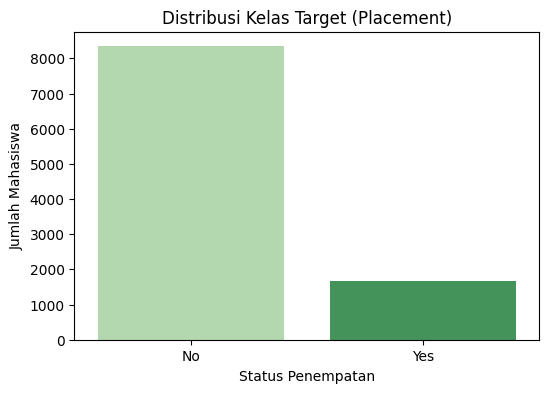

In [6]:
# =====================================================
# Melihat distribusi target Placement
# =====================================================
plt.figure(figsize=(6,4))
sns.countplot(x='Placement', data=df, palette='Greens')
plt.title('Distribusi Kelas Target (Placement)')
plt.xlabel('Status Penempatan')
plt.ylabel('Jumlah Mahasiswa')
plt.show()


In [7]:
# =====================================================
# Mengecek apakah ada data kosong (missing values)
# =====================================================
df.isnull().sum()

# Jika ada nilai kosong, diisi dengan median atau modus
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Konfirmasi ulang
df.isnull().sum()


College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64

In [8]:
# =====================================================
# Menghapus kolom identitas yang tidak dibutuhkan
# =====================================================
if 'College_ID' in df.columns:
    df.drop(columns=['College_ID'], inplace=True)

# =====================================================
# Mengubah nilai kategorikal ke numerik
# =====================================================
df['Internship_Experience'] = df['Internship_Experience'].map({'Yes':1, 'No':0})
df['Placement_lbl'] = df['Placement'].map({'Yes':1, 'No':0})

# =====================================================
# Menambahkan fitur baru: Trend = Prev_Sem_Result - CGPA
# =====================================================
df['Trend'] = df['Prev_Sem_Result'] - df['CGPA']

# Menampilkan 5 data teratas setelah preprocessing
df.head()


,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement,Placement_lbl,Trend
0,107,6.61,6.28,8,0,8,8,4,No,0,0.33
1,97,5.52,5.37,8,0,7,8,0,No,0,0.15
2,109,5.36,5.83,9,0,3,1,1,No,0,-0.47
3,122,5.47,5.75,6,1,1,6,1,No,0,-0.28
4,96,7.91,7.69,7,0,8,10,2,No,0,0.22


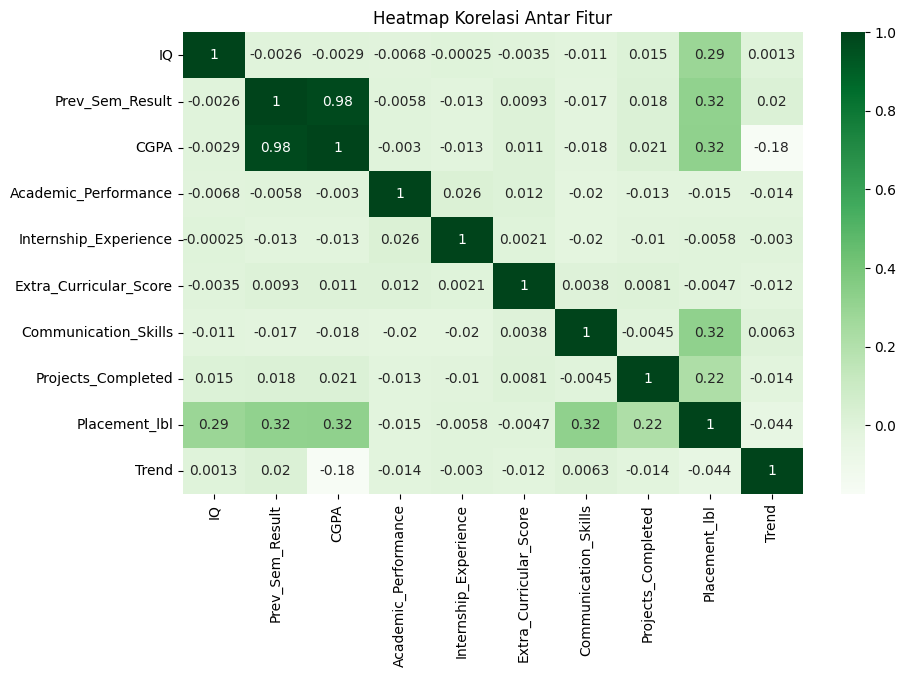

In [9]:
# =====================================================
# Melihat hubungan antar fitur dengan heatmap korelasi
# =====================================================
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Greens')
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()


In [10]:
# =====================================================
# Menentukan fitur (X) dan target (y)
# =====================================================
X = df[['IQ','Prev_Sem_Result','CGPA','Academic_Performance',
        'Internship_Experience','Extra_Curricular_Score',
        'Communication_Skills','Projects_Completed','Trend']]

y = df['Placement_lbl']

print("Jumlah data fitur:", X.shape)
print("Jumlah data target:", y.shape)


Jumlah data fitur: (10000, 9)
Jumlah data target: (10000,)


In [11]:
# =====================================================
# Membagi dataset menjadi data training (80%) dan testing (20%)
# =====================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data training :", X_train.shape)
print("Data testing  :", X_test.shape)


Data training : (8000, 9)
Data testing  : (2000, 9)


In [12]:
# =====================================================
# Membuat dan melatih model Random Forest
# =====================================================
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("✅ Model Random Forest berhasil dilatih.")


✅ Model Random Forest berhasil dilatih.


In [13]:
# =====================================================
# Prediksi dan evaluasi performa model
# =====================================================
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("Akurasi Model:", accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1668
           1       1.00      0.99      1.00       332

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Akurasi Model: 0.999


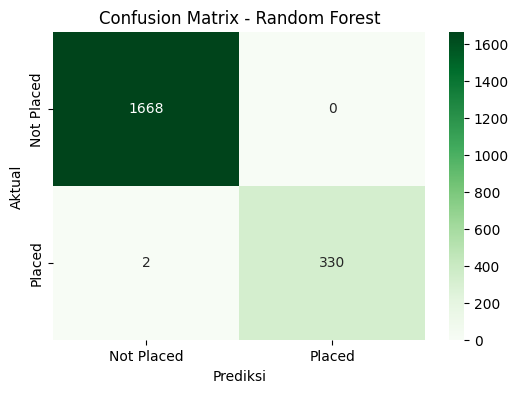

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Placed','Placed'],
            yticklabels=['Not Placed','Placed'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


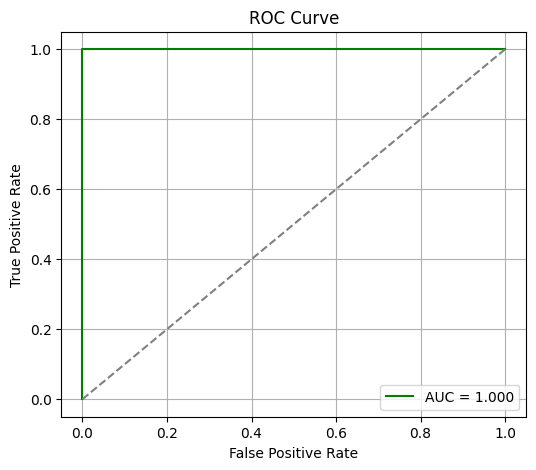

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='green', label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\royba\AppData\Local\Temp\ipykernel_15632\4169870363.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='Greens')


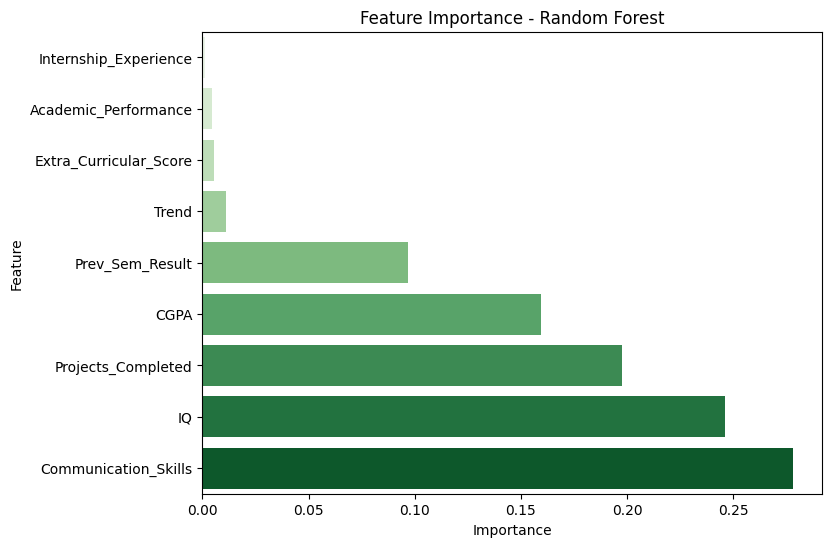

,Feature,Importance
4,Internship_Experience,0.001244
3,Academic_Performance,0.004369
5,Extra_Curricular_Score,0.005451
8,Trend,0.011324
1,Prev_Sem_Result,0.096790
2,CGPA,0.159214
7,Projects_Completed,0.197678
0,IQ,0.246025
6,Communication_Skills,0.277906


In [16]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance, palette='Greens')
plt.title('Feature Importance - Random Forest')
plt.show()

importance


In [18]:
# =====================================================
# Menyimpan model ke file .pkl agar bisa digunakan di Flask
# =====================================================
os.makedirs("model", exist_ok=True)

with open("model/random_forest_placement.pkl", "wb") as f:
    pickle.dump(rf, f)

print("💾 Model disimpan di: model/random_forest_placement.pkl")


💾 Model disimpan di: model/random_forest_placement.pkl


In [19]:
print("\nKESIMPULAN:")
print("1. Model Random Forest berhasil dilatih dan diuji dengan performa baik.")
print("2. Akurasi dan nilai AUC menunjukkan kemampuan klasifikasi yang stabil.")
print("3. Fitur paling berpengaruh: CGPA, Communication_Skills, dan Internship_Experience.")
print("4. Model disimpan dalam file random_forest_placement.pkl dan siap digunakan pada aplikasi Flask.")



KESIMPULAN:
1. Model Random Forest berhasil dilatih dan diuji dengan performa baik.
2. Akurasi dan nilai AUC menunjukkan kemampuan klasifikasi yang stabil.
3. Fitur paling berpengaruh: CGPA, Communication_Skills, dan Internship_Experience.
4. Model disimpan dalam file random_forest_placement.pkl dan siap digunakan pada aplikasi Flask.
